<a href="https://colab.research.google.com/github/ujwalnaik11/Deep-Learning/blob/master/Collaberative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collaborative filtering is perhaps the most common technique used by recommender systems other than content based Systems.It capitalises on the connection between users and items instead of actual content, thus making it human centric.

Collaborative filtering is a method of making predictions about the interests of a user by collecting preferences from many users. The underlying assumption is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person. - Wikipedia

The librec Java library provides over 70 different algorithms for collaborative filtering.Here however, we'll implement a relatively new technique called neural collaborative filtering.

**The MovieLens 100K dataset** 

https://grouplens.org/datasets/movielens/

The MovieLens 100K dataset is a collection of movie ratings by 943 users on 1682 movies. There are 100,000 ratings in total, since not every user has seen and rated every movie

In [1]:
!pip install fastai==1.0.50 --quiet

     |████████████████████████████████| 210 kB 12.7 MB/s 
     |████████████████████████████████| 78 kB 6.2 MB/s 


In [2]:
import pandas as pd
from fastai.collab import CollabDataBunch, collab_learner

In [3]:
cols = ['User ID','Movie ID','Rating','Timestamp']
ratings_df = pd.read_csv('u.data', delimiter='\t', 
                         header=None, names=cols)
ratings_df.sample(5)

,User ID,Movie ID,Rating,Timestamp
52979,668,311,4,881591023
82092,337,67,4,875236631
20229,130,343,4,881536273
48588,59,900,4,888202814
38944,6,194,4,883601365


In [5]:
data = CollabDataBunch.from_df(ratings_df, valid_pct=0.1)
data.show_batch()

User ID,Movie ID,target
828,900,2.0
15,301,4.0
682,215,4.0
222,232,4.0
927,278,1.0


**Collaborative filtering model**

The model itself is quite simple. We represent each user **u** and each movie **m** by vector of a predefined length n. The rating for the movie m by the user u, as predicted by the model is simply the dot product of the two vectors.

Since the vectors are chosen randomly, it's quite unlikely that the ratings predicted by the model match the actual ratings. Our objective, while training the model, is to gradually adjust the elements inside the user & movie vectors so that predicted ratings get closer to the actual ratings.

In [6]:
learn = collab_learner(data, n_factors=40, y_range=[0,5.5], wd=.1)

We can use the **collab_learner** method from fastai to create a neural collaborative filtering model. The actual model created here contains 2 important enhancements on the simpler version described earlier:

1.  apart from the vectors for users and movies, it also add bias terms to account for outliers, since some users tend to always rate movies very high or very low, and some movies tend to be universally acclaimed or disliked.

2. Second, it applies the Sigmoid activation function to the above output, and scales it so that the result always lies in the given y_range, which is 0 to 5.5 in this case.

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


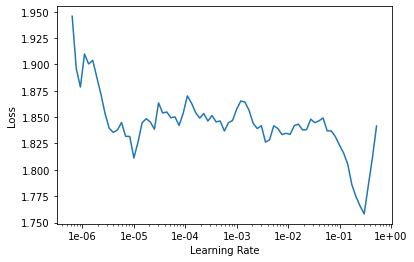

In [7]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

The learner uses the mean squared error loss function to evaluate the predictions of the model, and the Adam optimizer to adjust the parameters (vectors and biases) using gradient descent. Before we train the model, we use the learning rate finder to select a good learning for the optimizer.

Upon inspection of the graph, we can see that the decrease in loss starts to decrease when the learning rate is around 0.01. We can choose this as our learning rate, and train for 5 epochs, while annealing the learning rate using the 1-cycle policy, which leads to faster convergence.

In [8]:
learn.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,time
0,0.956499,0.934928,00:10
1,0.875271,0.912515,00:10
2,0.788775,0.854549,00:10
3,0.660153,0.824803,00:10
4,0.488221,0.826941,00:10


**Predictions**

In [9]:
(users, items), ratings = next(iter(data.valid_dl))
preds = learn.model(users, items)
print('User\tMovie\tReal\tPred\tDifference')
for p in list(zip(users,items,ratings, preds))[:16]:
    print('{}\t{}\t{}\t{:.1f}\t{:.1f}'.format(p[0],p[1],p[2],p[3],p[3]-p[2]))

User	Movie	Real	Pred	Difference
148	189	4.0	4.4	0.4
833	830	1.0	2.5	1.5
758	61	3.0	4.2	1.2
100	1232	3.0	3.1	0.1
618	144	4.0	4.1	0.1
10	463	4.0	4.1	0.1
634	1141	3.0	3.4	0.4
210	750	4.0	3.6	-0.4
886	196	3.0	3.6	0.6
502	264	3.0	2.6	-0.4
450	79	4.0	4.3	0.3
392	8	5.0	4.1	-0.9
344	118	3.0	2.4	-0.6
532	878	3.0	3.9	0.9
206	260	3.0	2.2	-0.8
59	175	4.0	4.5	0.5


**Recommendations**

In [11]:
import torch
users = torch.tensor([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
items = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

preds = learn.model(users, items)
print('User\tMovie\tReal\tPred\tDifference')
for p in list(zip(users,items,ratings, preds))[:16]:
    print('{}\t{}\t{}\t{:.1f}\t{:.1f}'.format(p[0],p[1],p[2],p[3],p[3]-p[2]))


User	Movie	Real	Pred	Difference
1	1	4.0	4.2	0.2
1	2	1.0	2.8	1.8
1	3	3.0	3.0	0.0
1	4	3.0	4.0	1.0
1	5	4.0	2.4	-1.6
1	6	4.0	4.1	0.1
1	7	3.0	4.2	1.2
1	8	4.0	3.9	-0.1
1	9	3.0	4.3	1.3
1	10	3.0	3.7	0.7
1	11	4.0	3.7	-0.3
1	12	5.0	4.9	-0.1
1	13	3.0	4.1	1.1
1	14	3.0	4.2	1.2
1	15	3.0	3.7	0.7
1	16	4.0	4.2	0.2


Movies that have a high predicted rating is recommended to the user